In [1]:
# Instal libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

In [2]:
# Load data
df = pd.read_csv('/content/Loan.csv')

In [3]:
df.head()

,ApplicationDate,Age,AnnualIncome,CreditScore,EmploymentStatus,EducationLevel,Experience,LoanAmount,LoanDuration,MaritalStatus,...,MonthlyIncome,UtilityBillsPaymentHistory,JobTenure,NetWorth,BaseInterestRate,InterestRate,MonthlyLoanPayment,TotalDebtToIncomeRatio,LoanApproved,RiskScore
0,2018-01-01,45,39948,617,Employed,Master,22,13152,48,Married,...,3329.000000,0.724972,11,126928,0.199652,0.227590,419.805992,0.181077,0,49.0
1,2018-01-02,38,39709,628,Employed,Associate,15,26045,48,Single,...,3309.083333,0.935132,3,43609,0.207045,0.201077,794.054238,0.389852,0,52.0
2,2018-01-03,47,40724,570,Employed,Bachelor,26,17627,36,Married,...,3393.666667,0.872241,6,5205,0.217627,0.212548,666.406688,0.462157,0,52.0
3,2018-01-04,58,69084,545,Employed,High School,34,37898,96,Single,...,5757.000000,0.896155,5,99452,0.300398,0.300911,1047.506980,0.313098,0,54.0
4,2018-01-05,37,103264,594,Employed,Associate,17,9184,36,Married,...,8605.333333,0.941369,5,227019,0.197184,0.175990,330.179140,0.070210,1,36.0


# Split Data

In [4]:
# Define features & target
X = df.drop(['LoanApproved'], axis=1)
y = df['LoanApproved']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Train shape: {X_train.shape}")
print(f"Test shape: {X_test.shape}")

Train shape: (16000, 35)
Test shape: (4000, 35)


# Data Preprocessing

In [5]:
# Drop column
X_train.drop(['ApplicationDate', 'Age', 'AnnualIncome', 'TotalAssets', 'BaseInterestRate'], axis=1, inplace=True)
X_test.drop(['ApplicationDate', 'Age', 'AnnualIncome', 'TotalAssets', 'BaseInterestRate'], axis=1, inplace=True)

In [6]:
# Feature engeneering
X_train['LoanDurationYears'] = X_train['LoanDuration'] / 12
X_test['LoanDurationYears'] = X_test['LoanDuration'] / 12

In [7]:
# Encoding
cat_cols = X_train.select_dtypes(include='object').columns.tolist()
print("Categorical Columns:", cat_cols)

# OneHot Encoding
ohe = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')

X_train_ohe = pd.DataFrame(
    ohe.fit_transform(X_train[cat_cols]),
    columns=ohe.get_feature_names_out(cat_cols),
    index=X_train.index
)

X_test_ohe = pd.DataFrame(
    ohe.transform(X_test[cat_cols]),
    columns=ohe.get_feature_names_out(cat_cols),
    index=X_test.index
)

# Drop original categorical columns & concat encoded
X_train = pd.concat([X_train.drop(cat_cols, axis=1), X_train_ohe], axis=1)
X_test = pd.concat([X_test.drop(cat_cols, axis=1), X_test_ohe], axis=1)

Categorical Columns: ['EmploymentStatus', 'EducationLevel', 'MaritalStatus', 'HomeOwnershipStatus', 'LoanPurpose']


In [8]:
# Scaling
num_features = [
    'CreditScore', 'Experience', 'LoanAmount', 'LoanDurationYears',
    'MonthlyDebtPayments', 'CreditCardUtilizationRate',
    'NumberOfOpenCreditLines', 'NumberOfCreditInquiries',
    'DebtToIncomeRatio', 'PaymentHistory', 'LengthOfCreditHistory',
    'SavingsAccountBalance', 'CheckingAccountBalance',
    'TotalLiabilities', 'MonthlyIncome', 'UtilityBillsPaymentHistory',
    'JobTenure', 'NetWorth', 'InterestRate', 'MonthlyLoanPayment',
    'TotalDebtToIncomeRatio', 'RiskScore'
]

# Scale numeric features
scaler = RobustScaler()

# Scale only numeric columns
X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train[num_features]),
    columns=num_features,
    index=X_train.index
)
X_test_scaled = pd.DataFrame(
    scaler.transform(X_test[num_features]),
    columns=num_features,
    index=X_test.index
)

# Combine scaled numeric + non-scaled features
X_train_final = pd.concat(
    [X_train_scaled, X_train.drop(columns=num_features, errors='ignore')], axis=1
)
X_test_final = pd.concat(
    [X_test_scaled, X_test.drop(columns=num_features, errors='ignore')], axis=1
)

print(f"Train shape: {X_train_final.shape}")
print(f"Test shape: {X_test_final.shape}")

Train shape: (16000, 42)
Test shape: (4000, 42)


## Selected feature

In [9]:
selected_features = [
    'RiskScore', 'DebtToIncomeRatio', 'BankruptcyHistory', 'CreditScore', 'NetWorth',
    'MonthlyIncome', 'LoanAmount', 'InterestRate', 'PreviousLoanDefaults', 'CreditCardUtilizationRate'
  ]

X_train_sel = X_train_final[selected_features]
X_test_sel = X_test_final[selected_features]

# Modeling

In [10]:
# Train model
model = LGBMClassifier(n_estimators=200, num_leaves=15, random_state=42, class_weight='balanced')

model.fit(X_train_sel, y_train)

[LightGBM] [Info] Number of positive: 3763, number of negative: 12237
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001729 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1826
[LightGBM] [Info] Number of data points in the train set: 16000, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


LGBMClassifier(class_weight='balanced', n_estimators=200, num_leaves=15,
               random_state=42)

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      2983
           1       1.00      1.00      1.00      1017

    accuracy                           1.00      4000
   macro avg       1.00      1.00      1.00      4000
weighted avg       1.00      1.00      1.00      4000

AUC-ROC: 0.9999976925949768


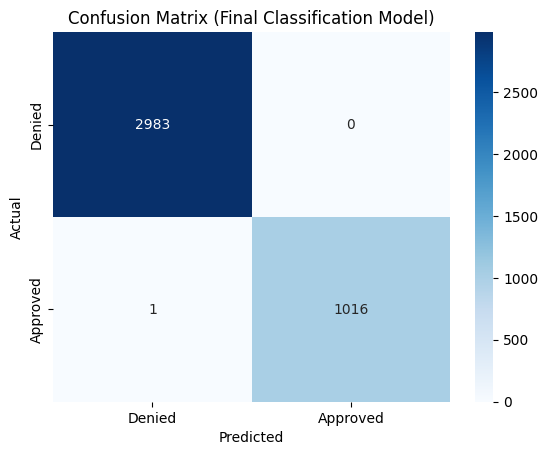

In [11]:
# Check model's performance
y_pred = model.predict(X_test_sel)
y_pred_proba = model.predict_proba(X_test_sel)[:, 1]

# Classification report & AUC
print("Classification Report:\n", classification_report(y_test, y_pred))
print("AUC-ROC:", roc_auc_score(y_test, y_pred_proba))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues",
            xticklabels=["Denied", "Approved"],
            yticklabels=["Denied", "Approved"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (Final Classification Model)")
plt.show()

# Save trained model and preprocessors

In [12]:
joblib.dump(model, 'lgbm_classifier.pkl')
joblib.dump(scaler, 'clf_scaler.pkl')
joblib.dump(ohe, 'encoder.pkl')

print("Model, scaler, and encoder saved successfully!")

Model, scaler, and encoder saved successfully!
